In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob, math, re

# --- Config ---
BASE = Path("/Users/juliahagen/IntMS_EEG/data/preprocessing")
PATIENT_DIRS = {
    "P1": BASE / "P1_prp_feat",
    "P3": BASE / "P3_prp_feat",
    "P5": BASE / "P5_prp_feat",
}
PLOT_OUT = Path("./patient_correlations.png")

# Possible inputs
INPUTS = {
    "RMS_EMG": lambda R, _: R,       # your RMSed EMG bins
    #"RAW_EMG": lambda R, _: R_raw, # placeholder if you also want raw EMG later
}

# Possible targets
TARGETS = {
    "Fx": lambda _, Fx, Fy, Mag: Fx,
    "Fy": lambda _, Fx, Fy, Mag: Fy,
    "Mag": lambda _, Fx, Fy, Mag: Mag,
    "Angle": lambda _, Fx, Fy, Mag: np.arctan2(Fy, Fx),  # or directly from fname
}



# --- Helpers ---
def angle_from_fname(fname):
    base = Path(fname).stem
    first = base.split('_', 1)[0]
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', first)
    if m:
        return float(m.group(1))
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*deg', base, flags=re.IGNORECASE)
    if m:
        return float(m.group(1))
    raise ValueError(f"Cannot parse angle from {fname}")

def load_feature_file(path):
    obj = np.load(path, allow_pickle=True)
    d = {k: obj[k] for k in obj.files} if isinstance(obj, np.lib.npyio.NpzFile) else (obj.item() if hasattr(obj, "item") else obj)
    R   = np.asarray(d["emg_rms_matrix_binned"], dtype=float)
    mag = np.asarray(d["ref_binned"], dtype=float).reshape(-1)
    B   = min(R.shape[0], mag.shape[0])
    R, mag = R[:B, :], mag[:B]
    theta = math.radians(angle_from_fname(path))
    Fx = mag * math.cos(theta)
    Fy = mag * math.sin(theta)
    return R, Fx, Fy, mag

def pearson_corr(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) < 2 or np.std(x) == 0 or np.std(y) == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

# --- Main ---

rows = []
for patient, folder in PATIENT_DIRS.items():
    files = sorted(glob.glob(str(folder / "*.npy"))) + sorted(glob.glob(str(folder / "*.npz")))
    if not files:
        continue

    # aggregate
    all_R, all_Fx, all_Fy, all_Mag = [], [], [], []
    for f in files:
        R, Fx, Fy, Mag = load_feature_file(f)
        all_R.append(R); all_Fx.append(Fx); all_Fy.append(Fy); all_Mag.append(Mag)

    R_all  = np.vstack(all_R)
    Fx_all = np.concatenate(all_Fx)
    Fy_all = np.concatenate(all_Fy)
    Mag_all = np.concatenate(all_Mag)

    for in_name, in_fn in INPUTS.items():
        X = in_fn(R_all, None)   # extend later if you pass raw
        for tgt_name, tgt_fn in TARGETS.items():
            y = tgt_fn(None, Fx_all, Fy_all, Mag_all)

            # correlation per channel
            for ch in range(X.shape[1]):
                r = pearson_corr(X[:, ch], y)
                rows.append({
                    "patient": patient,
                    "input": in_name,
                    "target": tgt_name,
                    "channel": ch,
                    "corr": r
                })

df_corr = pd.DataFrame(rows)


rows = []
for patient, folder in PATIENT_DIRS.items():
    files = sorted(glob.glob(str(folder / "*.npy"))) + sorted(glob.glob(str(folder / "*.npz")))
    if not files:
        continue

    # aggregate
    all_R, all_Fx, all_Fy, all_Mag = [], [], [], []
    for f in files:
        R, Fx, Fy, Mag = load_feature_file(f)
        all_R.append(R); all_Fx.append(Fx); all_Fy.append(Fy); all_Mag.append(Mag)

    R_all  = np.vstack(all_R)
    Fx_all = np.concatenate(all_Fx)
    Fy_all = np.concatenate(all_Fy)
    Mag_all = np.concatenate(all_Mag)

    for in_name, in_fn in INPUTS.items():
        X = in_fn(R_all, None)   # extend later if you pass raw
        for tgt_name, tgt_fn in TARGETS.items():
            y = tgt_fn(None, Fx_all, Fy_all, Mag_all)

            # correlation per channel
            for ch in range(X.shape[1]):
                r = pearson_corr(X[:, ch], y)
                rows.append({
                    "patient": patient,
                    "input": in_name,
                    "target": tgt_name,
                    "channel": ch,
                    "corr": r
                })

df_corr = pd.DataFrame(rows)


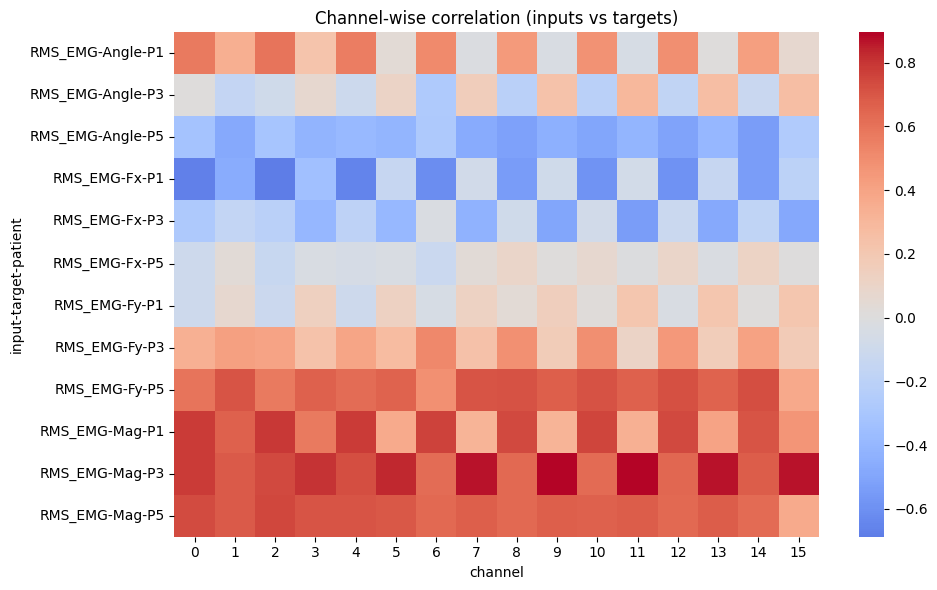

In [4]:
import seaborn as sns

plt.figure(figsize=(10,6))
pivot = df_corr.pivot_table(
    index=["input","target","patient"],
    columns="channel",
    values="corr"
)
sns.heatmap(pivot, cmap="coolwarm", center=0, annot=False)
plt.title("Channel-wise correlation (inputs vs targets)")
plt.tight_layout()
plt.show()


In [5]:
PLOTS_DIR = Path("./corr_plots")
PLOTS_DIR.mkdir(exist_ok=True)

# Turn on/off plot sets
PLOT_PER_PATIENT_COMBOS = True      # one figure per (Patient × Input × Target)
PLOT_AGG_PER_COMBO      = True      # one figure per (Input × Target), lines by patient

# Annotate every bar with r (rounded)
ANNOTATE_BARS = True


# ===================== Plotting =====================
def annotate_bars(ax, bars):
    if not ANNOTATE_BARS:
        return
    for b in bars:
        x = b.get_width()
        y = b.get_y() + b.get_height()/2
        ax.text(x + (0.02 if x>=0 else -0.02), y, f"{x:.2f}",
                va="center", ha="left" if x>=0 else "right", fontsize=8)

def plot_per_patient_combo(df, patient, input_name, target_name, outdir=PLOTS_DIR):
    sub = df[(df.patient==patient) & (df.input==input_name) & (df.target==target_name)].copy()
    if sub.empty:
        return
    sub = sub.sort_values("channel")
    fig, ax = plt.subplots(figsize=(8, 6))
    ylabels = [f"Ch {c}" for c in sub["channel"]]
    bars = ax.barh(ylabels, sub["corr"], height=0.6)
    ax.set_xlim(-1.0, 1.0)
    ax.set_xlabel(f"Pearson r  ({input_name} → {target_name})")
    ax.set_title(f"{patient} • {input_name} → {target_name}  |  mean r={np.nanmean(sub['corr']):.2f}")
    ax.axvline(0, lw=1, color="gray", alpha=0.7)
    ax.grid(axis="x", alpha=0.3)
    annotate_bars(ax, bars)
    plt.tight_layout()
    fname = outdir / f"{patient}_{input_name}_to_{target_name}.png"
    plt.savefig(fname, dpi=150)
    plt.close(fig)

def plot_agg_per_combo(df, input_name, target_name, outdir=PLOTS_DIR):
    sub = df[(df.input==input_name) & (df.target==target_name)].copy()
    if sub.empty:
        return
    channels = sorted(sub["channel"].unique())
    fig, ax = plt.subplots(figsize=(9, 5))
    for patient in sub["patient"].unique():
        s = sub[sub.patient==patient].sort_values("channel")
        ax.plot(s["channel"], s["corr"], marker="o", label=patient, linewidth=1)
    ax.set_ylim(-1.0, 1.0)
    ax.set_xlabel("Channel")
    ax.set_ylabel("Pearson r")
    ax.set_title(f"{input_name} → {target_name} (per patient)")
    ax.grid(True, alpha=0.3)
    ax.legend(title="Patient")
    plt.tight_layout()
    fname = outdir / f"ALL_{input_name}_to_{target_name}.png"
    plt.savefig(fname, dpi=150)
    plt.close(fig)

# ---- generate plots ----
if PLOT_PER_PATIENT_COMBOS:
    for patient in df_corr["patient"].unique():
        for inp in INPUTS:
            for tgt in TARGETS:
                plot_per_patient_combo(df_corr, patient, inp, tgt)

if PLOT_AGG_PER_COMBO:
    for inp in INPUTS:
        for tgt in TARGETS:
            plot_agg_per_combo(df_corr, inp, tgt)

print(f"Done. Plots in: {PLOTS_DIR.resolve()}")

Done. Plots in: /Users/juliahagen/IntMS_EEG/corr_plots


In [2]:
df_corr

,patient,channel,corr
0,P1,0,0.781392
1,P1,1,0.660334
2,P1,2,0.790688
3,P1,3,0.575932
4,P1,4,0.782768
5,P1,5,0.364916
6,P1,6,0.764002
7,P1,7,0.315206
8,P1,8,0.741472
9,P1,9,0.314985


In [3]:
mean_corr_per_patient = df_corr.groupby("patient")["corr"].mean()
print(mean_corr_per_patient)

patient
P1    0.593713
P3    0.761390
P5    0.660764
Name: corr, dtype: float64


In [4]:
from pathlib import Path
import numpy as np

p = Path("data/preprocessing/P3_prp_feat/90_F1_1_1.npy")  # <-- pick any file that exists
d = np.load(p, allow_pickle=True).item()
print("File:", p.name)
for k, v in d.items():
    try:
        print(f"  {k:28s} shape={np.shape(v)} dtype={getattr(v,'dtype',type(v))}")
    except Exception:
        print(f"  {k:28s} <non-array> type={type(v)}")


File: 90_F1_1_1.npy
  data                         shape=(16, 199687) dtype=float64
  ref_signal                   shape=(199687,) dtype=float64
  region_num                   shape=() dtype=<class 'int'>
  start_idx                    shape=() dtype=<class 'int'>
  end_idx                      shape=() dtype=<class 'int'>
  length                       shape=() dtype=<class 'int'>
  emg_rms_per_sample           shape=(199687,) dtype=float64
  emg_rms_binned               shape=(199,) dtype=float64
  emg_rms_matrix_binned        shape=(199, 16) dtype=float64
  ref_binned                   shape=(199,) dtype=float64
  bin_size                     shape=() dtype=<class 'int'>
  T_use_for_bins               shape=() dtype=<class 'int'>


[SAVE] results_feat/P3/summary_mse_vs_bins.csv


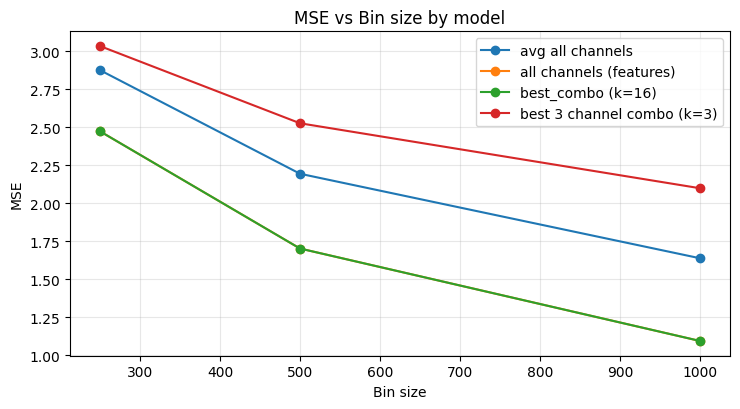

[PLOT] results_feat/P3/summary_mse_vs_bins.png

Selected common k for 'best combo': k=16


In [6]:
# file: plot_mse_vs_bins.py
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Config ----------------
RESULTS_BASE = Path("./results_feat/P3")   # <- change to your patient folder (e.g., ./results_feat/P1)
OUT_PNG      = RESULTS_BASE / "summary_mse_vs_bins.png"
OUT_CSV      = RESULTS_BASE / "summary_mse_vs_bins.csv"

# ---------------- Helpers ----------------
def _load_metrics_for_bin(bin_dir: Path) -> pd.DataFrame:
    f = bin_dir / "metrics.csv"
    if not f.exists():
        raise FileNotFoundError(f"Missing metrics.csv in {bin_dir}")
    df = pd.read_csv(f)
    # normalize types
    if "k_channels" in df.columns:
        # ensure integer for k where present
        df["k_channels"] = pd.to_numeric(df["k_channels"], errors="coerce").astype("Int64")
    return df

def _find_bin_dirs(base: Path):
    bins = {}
    for p in base.iterdir():
        if p.is_dir():
            m = re.match(r"bin_(\d+)$", p.name)
            if m:
                bins[int(m.group(1))] = p
    return dict(sorted(bins.items()))

# ---------------- Load all bins ----------------
bin_dirs = _find_bin_dirs(RESULTS_BASE)
if not bin_dirs:
    raise SystemExit(f"No bin_* folders found under {RESULTS_BASE}")

records = []   # collect per-bin metrics for required models
iter_by_bin = {}  # store iterative_add rows per bin

for bs, bdir in bin_dirs.items():
    df = _load_metrics_for_bin(bdir)

    # average_channels
    if not df[df["mode"] == "average_channels"].empty:
        mse_avg = float(df.loc[df["mode"] == "average_channels", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "avg_all_channels", "mse": mse_avg})
    else:
        print(f"[WARN] bin={bs}: no 'average_channels' row")

    # rms_matrix = all channels as separate features
    if not df[df["mode"] == "rms_matrix"].empty:
        mse_rms = float(df.loc[df["mode"] == "rms_matrix", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "all_channels_features", "mse": mse_rms})
    else:
        print(f"[WARN] bin={bs}: no 'rms_matrix' row")

    # iterative_add rows (for 'best combo' & 'k=3')
    df_it = df[df["mode"] == "iterative_add"].copy()
    if df_it.empty:
        print(f"[WARN] bin={bs}: no 'iterative_add' rows")
        iter_by_bin[bs] = pd.DataFrame(columns=["k_channels","mse"])
    else:
        df_it = df_it[["k_channels", "mse"]].dropna(subset=["k_channels"]).copy()
        df_it["k_channels"] = df_it["k_channels"].astype(int)
        iter_by_bin[bs] = df_it

        # Best 3 channel combo (k=3)
        hit = df_it[df_it["k_channels"] == 3]
        if not hit.empty:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": float(hit["mse"].iloc[0])})
        else:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": np.nan})

# ---------------- Choose "beste Kombi" (common k across bins if possible) ----------------
# Intersection of k across all bins
sets_of_k = [set(df_it["k_channels"].tolist()) for df_it in iter_by_bin.values() if not df_it.empty]
common_k = set.intersection(*sets_of_k) if sets_of_k else set()

if common_k:
    # pick k* that minimizes mean MSE across bins
    k_candidates = sorted(common_k)
    avg_mses = []
    for k in k_candidates:
        mses = []
        for bs, df_it in iter_by_bin.items():
            v = df_it.loc[df_it["k_channels"] == k, "mse"]
            if not v.empty:
                mses.append(float(v.iloc[0]))
        if mses:
            avg_mses.append((k, np.mean(mses)))
    # choose best k by lowest mean MSE
    selected_k = sorted(avg_mses, key=lambda t: t[1])[0][0]
    best_combo_label = f"best_combo (k={selected_k})"
    # collect per-bin MSE at this k
    for bs, df_it in iter_by_bin.items():
        v = df_it.loc[df_it["k_channels"] == selected_k, "mse"]
        mse = float(v.iloc[0]) if not v.empty else np.nan
        records.append({"bin_size": bs, "model": best_combo_label, "mse": mse, "k": selected_k})
else:
    # fallback: best k per bin (varies)
    best_combo_label = "best_combo (per-bin k)"
    for bs, df_it in iter_by_bin.items():
        if df_it.empty:
            records.append({"bin_size": bs, "model": best_combo_label, "mse": np.nan, "k": np.nan})
            continue
        row = df_it.sort_values("mse", ascending=True).iloc[0]
        records.append({"bin_size": bs, "model": best_combo_label, "mse": float(row["mse"]), "k": int(row["k_channels"])})

# ---------------- Build table & save ----------------
df_plot = pd.DataFrame(records)
# Pivot for CSV summary readability
summary = (df_plot
           .pivot_table(index="bin_size", columns="model", values="mse", aggfunc="first")
           .sort_index())
RESULTS_BASE.mkdir(parents=True, exist_ok=True)
summary.to_csv(OUT_CSV)
print(f"[SAVE] {OUT_CSV}")

# ---------------- Plot ----------------
plt.figure(figsize=(7.5, 4.2))
bin_sizes_sorted = sorted(bin_dirs.keys())

def _plot_line(model_key: str, label: str):
    sub = df_plot[df_plot["model"] == model_key].copy()
    y = [float(sub.loc[sub["bin_size"] == bs, "mse"].iloc[0]) if not sub.loc[sub["bin_size"] == bs, "mse"].empty else np.nan
         for bs in bin_sizes_sorted]
    plt.plot(bin_sizes_sorted, y, marker="o", label=label)
    return y

# 1) avg all channels
_plot_line("avg_all_channels", "avg all channels")

# 2) all channels as features
_plot_line("all_channels_features", "all channels (features)")

# 3) best combo (either fixed k across bins or per-bin)
_plot_line(best_combo_label, best_combo_label)

# 4) k=3 combo
_plot_line("k3_combo", "best 3 channel combo (k=3)")

plt.xlabel("Bin size")
plt.ylabel("MSE")
plt.title("MSE vs Bin size by model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
plt.show()
print(f"[PLOT] {OUT_PNG}")

# Optional: annotate per-bin k when using per-bin best combo
if best_combo_label == "best_combo (per-bin k)":
    sub = df_plot[df_plot["model"] == best_combo_label]
    ks = {int(r.bin_size): int(r.k) for r in sub.itertuples() if pd.notna(r.k)}
    print("\nChosen k per bin for 'best_combo (per-bin k)':")
    for bs in bin_sizes_sorted:
        print(f"  bin {bs}: k={ks.get(bs, 'NA')}")
else:
    k_txt = best_combo_label.split("k=")[1].rstrip(")") if "k=" in best_combo_label else "NA"
    print(f"\nSelected common k for 'best combo': k={k_txt}")



[SAVE] results_feat/P1/summary_mse_vs_bins.csv


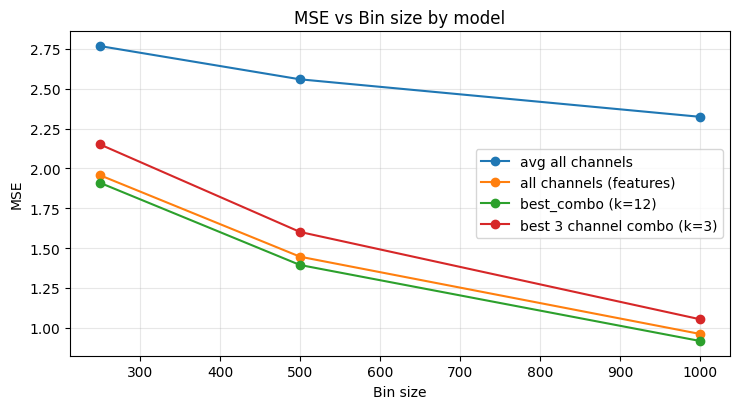

[PLOT] results_feat/P1/summary_mse_vs_bins.png

Selected common k for 'best combo': k=12


In [8]:
# file: plot_mse_vs_bins.py
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Config ----------------
RESULTS_BASE = Path("./results_feat/P1")   # <- change to your patient folder (e.g., ./results_feat/P1)
OUT_PNG      = RESULTS_BASE / "summary_mse_vs_bins.png"
OUT_CSV      = RESULTS_BASE / "summary_mse_vs_bins.csv"



# ---------------- Load all bins ----------------
bin_dirs = _find_bin_dirs(RESULTS_BASE)
if not bin_dirs:
    raise SystemExit(f"No bin_* folders found under {RESULTS_BASE}")

records = []   # collect per-bin metrics for required models
iter_by_bin = {}  # store iterative_add rows per bin

for bs, bdir in bin_dirs.items():
    df = _load_metrics_for_bin(bdir)

    # average_channels
    if not df[df["mode"] == "average_channels"].empty:
        mse_avg = float(df.loc[df["mode"] == "average_channels", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "avg_all_channels", "mse": mse_avg})
    else:
        print(f"[WARN] bin={bs}: no 'average_channels' row")

    # rms_matrix = all channels as separate features
    if not df[df["mode"] == "rms_matrix"].empty:
        mse_rms = float(df.loc[df["mode"] == "rms_matrix", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "all_channels_features", "mse": mse_rms})
    else:
        print(f"[WARN] bin={bs}: no 'rms_matrix' row")

    # iterative_add rows (for 'best combo' & 'k=3')
    df_it = df[df["mode"] == "iterative_add"].copy()
    if df_it.empty:
        print(f"[WARN] bin={bs}: no 'iterative_add' rows")
        iter_by_bin[bs] = pd.DataFrame(columns=["k_channels","mse"])
    else:
        df_it = df_it[["k_channels", "mse"]].dropna(subset=["k_channels"]).copy()
        df_it["k_channels"] = df_it["k_channels"].astype(int)
        iter_by_bin[bs] = df_it

        # Best 3 channel combo (k=3)
        hit = df_it[df_it["k_channels"] == 3]
        if not hit.empty:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": float(hit["mse"].iloc[0])})
        else:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": np.nan})

# ---------------- Choose "beste Kombi" (common k across bins if possible) ----------------
# Intersection of k across all bins
sets_of_k = [set(df_it["k_channels"].tolist()) for df_it in iter_by_bin.values() if not df_it.empty]
common_k = set.intersection(*sets_of_k) if sets_of_k else set()

if common_k:
    # pick k* that minimizes mean MSE across bins
    k_candidates = sorted(common_k)
    avg_mses = []
    for k in k_candidates:
        mses = []
        for bs, df_it in iter_by_bin.items():
            v = df_it.loc[df_it["k_channels"] == k, "mse"]
            if not v.empty:
                mses.append(float(v.iloc[0]))
        if mses:
            avg_mses.append((k, np.mean(mses)))
    # choose best k by lowest mean MSE
    selected_k = sorted(avg_mses, key=lambda t: t[1])[0][0]
    best_combo_label = f"best_combo (k={selected_k})"
    # collect per-bin MSE at this k
    for bs, df_it in iter_by_bin.items():
        v = df_it.loc[df_it["k_channels"] == selected_k, "mse"]
        mse = float(v.iloc[0]) if not v.empty else np.nan
        records.append({"bin_size": bs, "model": best_combo_label, "mse": mse, "k": selected_k})
else:
    # fallback: best k per bin (varies)
    best_combo_label = "best_combo (per-bin k)"
    for bs, df_it in iter_by_bin.items():
        if df_it.empty:
            records.append({"bin_size": bs, "model": best_combo_label, "mse": np.nan, "k": np.nan})
            continue
        row = df_it.sort_values("mse", ascending=True).iloc[0]
        records.append({"bin_size": bs, "model": best_combo_label, "mse": float(row["mse"]), "k": int(row["k_channels"])})

# ---------------- Build table & save ----------------
df_plot = pd.DataFrame(records)
# Pivot for CSV summary readability
summary = (df_plot
           .pivot_table(index="bin_size", columns="model", values="mse", aggfunc="first")
           .sort_index())
RESULTS_BASE.mkdir(parents=True, exist_ok=True)
summary.to_csv(OUT_CSV)
print(f"[SAVE] {OUT_CSV}")

# ---------------- Plot ----------------
plt.figure(figsize=(7.5, 4.2))
bin_sizes_sorted = sorted(bin_dirs.keys())

def _plot_line(model_key: str, label: str):
    sub = df_plot[df_plot["model"] == model_key].copy()
    y = [float(sub.loc[sub["bin_size"] == bs, "mse"].iloc[0]) if not sub.loc[sub["bin_size"] == bs, "mse"].empty else np.nan
         for bs in bin_sizes_sorted]
    plt.plot(bin_sizes_sorted, y, marker="o", label=label)
    return y

# 1) avg all channels
_plot_line("avg_all_channels", "avg all channels")

# 2) all channels as features
_plot_line("all_channels_features", "all channels (features)")

# 3) best combo (either fixed k across bins or per-bin)
_plot_line(best_combo_label, best_combo_label)

# 4) k=3 combo
_plot_line("k3_combo", "best 3 channel combo (k=3)")

plt.xlabel("Bin size")
plt.ylabel("MSE")
plt.title("MSE vs Bin size by model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
plt.show()
print(f"[PLOT] {OUT_PNG}")

# Optional: annotate per-bin k when using per-bin best combo
if best_combo_label == "best_combo (per-bin k)":
    sub = df_plot[df_plot["model"] == best_combo_label]
    ks = {int(r.bin_size): int(r.k) for r in sub.itertuples() if pd.notna(r.k)}
    print("\nChosen k per bin for 'best_combo (per-bin k)':")
    for bs in bin_sizes_sorted:
        print(f"  bin {bs}: k={ks.get(bs, 'NA')}")
else:
    k_txt = best_combo_label.split("k=")[1].rstrip(")") if "k=" in best_combo_label else "NA"
    print(f"\nSelected common k for 'best combo': k={k_txt}")

[SAVE] results_feat/P5/summary_mse_vs_bins.csv


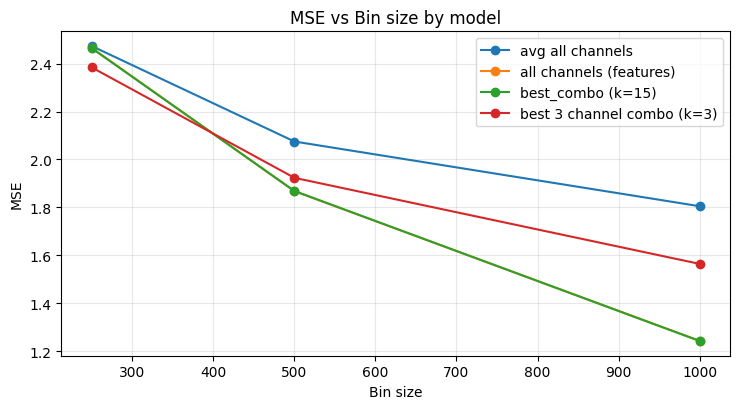

[PLOT] results_feat/P5/summary_mse_vs_bins.png

Selected common k for 'best combo': k=15


In [9]:
# file: plot_mse_vs_bins.py
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Config ----------------
RESULTS_BASE = Path("./results_feat/P5")   # <- change to your patient folder (e.g., ./results_feat/P1)
OUT_PNG      = RESULTS_BASE / "summary_mse_vs_bins.png"
OUT_CSV      = RESULTS_BASE / "summary_mse_vs_bins.csv"



# ---------------- Load all bins ----------------
bin_dirs = _find_bin_dirs(RESULTS_BASE)
if not bin_dirs:
    raise SystemExit(f"No bin_* folders found under {RESULTS_BASE}")

records = []   # collect per-bin metrics for required models
iter_by_bin = {}  # store iterative_add rows per bin

for bs, bdir in bin_dirs.items():
    df = _load_metrics_for_bin(bdir)

    # average_channels
    if not df[df["mode"] == "average_channels"].empty:
        mse_avg = float(df.loc[df["mode"] == "average_channels", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "avg_all_channels", "mse": mse_avg})
    else:
        print(f"[WARN] bin={bs}: no 'average_channels' row")

    # rms_matrix = all channels as separate features
    if not df[df["mode"] == "rms_matrix"].empty:
        mse_rms = float(df.loc[df["mode"] == "rms_matrix", "mse"].iloc[0])
        records.append({"bin_size": bs, "model": "all_channels_features", "mse": mse_rms})
    else:
        print(f"[WARN] bin={bs}: no 'rms_matrix' row")

    # iterative_add rows (for 'best combo' & 'k=3')
    df_it = df[df["mode"] == "iterative_add"].copy()
    if df_it.empty:
        print(f"[WARN] bin={bs}: no 'iterative_add' rows")
        iter_by_bin[bs] = pd.DataFrame(columns=["k_channels","mse"])
    else:
        df_it = df_it[["k_channels", "mse"]].dropna(subset=["k_channels"]).copy()
        df_it["k_channels"] = df_it["k_channels"].astype(int)
        iter_by_bin[bs] = df_it

        # Best 3 channel combo (k=3)
        hit = df_it[df_it["k_channels"] == 3]
        if not hit.empty:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": float(hit["mse"].iloc[0])})
        else:
            records.append({"bin_size": bs, "model": "k3_combo", "mse": np.nan})

# ---------------- Choose "beste Kombi" (common k across bins if possible) ----------------
# Intersection of k across all bins
sets_of_k = [set(df_it["k_channels"].tolist()) for df_it in iter_by_bin.values() if not df_it.empty]
common_k = set.intersection(*sets_of_k) if sets_of_k else set()

if common_k:
    # pick k* that minimizes mean MSE across bins
    k_candidates = sorted(common_k)
    avg_mses = []
    for k in k_candidates:
        mses = []
        for bs, df_it in iter_by_bin.items():
            v = df_it.loc[df_it["k_channels"] == k, "mse"]
            if not v.empty:
                mses.append(float(v.iloc[0]))
        if mses:
            avg_mses.append((k, np.mean(mses)))
    # choose best k by lowest mean MSE
    selected_k = sorted(avg_mses, key=lambda t: t[1])[0][0]
    best_combo_label = f"best_combo (k={selected_k})"
    # collect per-bin MSE at this k
    for bs, df_it in iter_by_bin.items():
        v = df_it.loc[df_it["k_channels"] == selected_k, "mse"]
        mse = float(v.iloc[0]) if not v.empty else np.nan
        records.append({"bin_size": bs, "model": best_combo_label, "mse": mse, "k": selected_k})
else:
    # fallback: best k per bin (varies)
    best_combo_label = "best_combo (per-bin k)"
    for bs, df_it in iter_by_bin.items():
        if df_it.empty:
            records.append({"bin_size": bs, "model": best_combo_label, "mse": np.nan, "k": np.nan})
            continue
        row = df_it.sort_values("mse", ascending=True).iloc[0]
        records.append({"bin_size": bs, "model": best_combo_label, "mse": float(row["mse"]), "k": int(row["k_channels"])})

# ---------------- Build table & save ----------------
df_plot = pd.DataFrame(records)
# Pivot for CSV summary readability
summary = (df_plot
           .pivot_table(index="bin_size", columns="model", values="mse", aggfunc="first")
           .sort_index())
RESULTS_BASE.mkdir(parents=True, exist_ok=True)
summary.to_csv(OUT_CSV)
print(f"[SAVE] {OUT_CSV}")

# ---------------- Plot ----------------
plt.figure(figsize=(7.5, 4.2))
bin_sizes_sorted = sorted(bin_dirs.keys())

def _plot_line(model_key: str, label: str):
    sub = df_plot[df_plot["model"] == model_key].copy()
    y = [float(sub.loc[sub["bin_size"] == bs, "mse"].iloc[0]) if not sub.loc[sub["bin_size"] == bs, "mse"].empty else np.nan
         for bs in bin_sizes_sorted]
    plt.plot(bin_sizes_sorted, y, marker="o", label=label)
    return y

# 1) avg all channels
_plot_line("avg_all_channels", "avg all channels")

# 2) all channels as features
_plot_line("all_channels_features", "all channels (features)")

# 3) best combo (either fixed k across bins or per-bin)
_plot_line(best_combo_label, best_combo_label)

# 4) k=3 combo
_plot_line("k3_combo", "best 3 channel combo (k=3)")

plt.xlabel("Bin size")
plt.ylabel("MSE")
plt.title("MSE vs Bin size by model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
plt.show()
print(f"[PLOT] {OUT_PNG}")

# Optional: annotate per-bin k when using per-bin best combo
if best_combo_label == "best_combo (per-bin k)":
    sub = df_plot[df_plot["model"] == best_combo_label]
    ks = {int(r.bin_size): int(r.k) for r in sub.itertuples() if pd.notna(r.k)}
    print("\nChosen k per bin for 'best_combo (per-bin k)':")
    for bs in bin_sizes_sorted:
        print(f"  bin {bs}: k={ks.get(bs, 'NA')}")
else:
    k_txt = best_combo_label.split("k=")[1].rstrip(")") if "k=" in best_combo_label else "NA"
    print(f"\nSelected common k for 'best combo': k={k_txt}")